In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape


from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_256.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 5.58 s, sys: 5.25 s, total: 10.8 s
Wall time: 1min 5s


In [5]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*4)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [6]:
%time t = next(train_generator(256))[0][0].T

CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 95.9 ms


In [7]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [92]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [13]:
p = 0.3


In [19]:
timesteps, input_dim , latent_dim = 32,256, 128

input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)


#original
x = BatchNormalization()(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same', name="latent")(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)


x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

autoencoder = Model(input_img, decoded)

In [20]:
autoencoder.load_weights("./weights/ae_wtest_conv_rmse_highres.hdf5")

In [21]:
for l in autoencoder.layers:
    l.trainable = False

In [25]:
x = BatchNormalization()(autoencoder.get_layer("latent").output)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)

x_max = GlobalMaxPool2D()(x)
x_avg = GlobalAveragePooling2D()(x)

x =  concatenate([x_max,x_avg])

x = Dense(128, activation = 'relu')(x) #
x = Dropout(p)(x)


x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)


In [26]:

model = Model(inputs=[input_img], outputs = x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 256)       0                                            
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 32, 256, 1)    0           input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_7 (BatchNorm (None, 32, 256, 1)    4           reshape_5[0][0]                  
____________________________________________________________________________________________________
conv2d_27 (Conv2D)               (None, 32, 256, 64)   1664        batch_normalization_7[0][0]      
___________________________________________________________________________________________

Epoch 14/100
300/300 [==============================] - 214s - loss: 0.7612 - acc: 0.7370 - val_loss: 1.0481 - val_acc: 0.6508



Epoch 31/100
350/350 [==============================] - 227s - loss: 0.4294 - acc: 0.8518 - val_loss: 0.9436 - val_acc: 0.7179
Epoch 32/100



Epoch 00058: reducing learning rate to 1.00000006569e-06.
329/329 [==============================] - 191s - loss: 0.7292 - acc: 0.7521 - val_loss: 0.7132 - val_acc: 0.8770


with ae, p=0.
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.3312 - acc: 0.8829 - val_loss: 0.4124 - val_acc: 0.8579

with p=0.4 and /2 for convs 
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.5534 - acc: 0.8056 - val_loss: 0.5074 - val_acc: 0.8312

with p=0.2 and /2
Epoch 00035: reducing learning rate to 1.0000000475e-05.
329/329 [==============================] - 7s - loss: 0.2414 - acc: 0.9137 - val_loss: 0.3686 - val_acc: 0.8811

In [56]:
train_df.shape[0]*(1.2)//64

395.71875

In [29]:
exp_name = "aebase_256_noaug_drp3_frozen"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')]

In [30]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.4)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
461/461 [==============================] - 60s - loss: 1.7964 - acc: 0.3911 - val_loss: 2.1263 - val_acc: 0.2809
Epoch 2/100
461/461 [==============================] - 57s - loss: 1.1111 - acc: 0.6096 - val_loss: 0.8016 - val_acc: 0.7195
Epoch 3/100
461/461 [==============================] - 55s - loss: 0.8245 - acc: 0.7109 - val_loss: 0.7039 - val_acc: 0.7582
Epoch 4/100
461/461 [==============================] - 55s - loss: 0.6683 - acc: 0.7696 - val_loss: 0.5869 - val_acc: 0.7929
Epoch 5/100
461/461 [==============================] - 55s - loss: 0.5943 - acc: 0.7962 - val_loss: 0.5245 - val_acc: 0.8196
Epoch 6/100
461/461 [==============================] - 55s - loss: 0.5155 - acc: 0.8234 - val_loss: 0.4890 - val_acc: 0.8335
Epoch 7/100
461/461 [==============================] - 55s - loss: 0.4830 - acc: 0.8315 - val_loss: 0.5239 - val_acc: 0.8216
Epoch 8/100
461/461 [==============================] - 55s - loss: 0.4459 - acc: 0.8469 - val_loss: 0.4931 - val_acc: 0.8226


KeyboardInterrupt: 

In [31]:
for l in model.layers:
    l.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [33]:
exp_name = "aebase_256_noaug_drp3_finetune"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)]

In [34]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
494/494 [==============================] - 122s - loss: 0.1890 - acc: 0.9360 - val_loss: 0.3053 - val_acc: 0.9030
Epoch 2/100
494/494 [==============================] - 119s - loss: 0.1825 - acc: 0.9371 - val_loss: 0.2947 - val_acc: 0.9092
Epoch 3/100
494/494 [==============================] - 119s - loss: 0.1743 - acc: 0.9412 - val_loss: 0.2877 - val_acc: 0.9065
Epoch 4/100
494/494 [==============================] - 119s - loss: 0.1689 - acc: 0.9435 - val_loss: 0.2846 - val_acc: 0.9085
Epoch 5/100
494/494 [==============================] - 119s - loss: 0.1650 - acc: 0.9449 - val_loss: 0.3172 - val_acc: 0.9019
Epoch 6/100
 51/494 [==>...........................] - ETA: 104s - loss: 0.1618 - acc: 0.9470

KeyboardInterrupt: 

In [385]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [386]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [387]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [31]:
val_preds.shape

(3091, 12)

In [388]:
oe = OneHotEncoder()

In [389]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [390]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [391]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.94      0.95       261
         no       0.82      0.85      0.84       270
         up       0.89      0.91      0.90       260
       down       0.92      0.88      0.90       264
       left       0.92      0.90      0.91       247
      right       0.97      0.86      0.91       256
         on       0.96      0.86      0.91       257
        off       0.92      0.88      0.90       256
       stop       0.96      0.87      0.91       246
         go       0.86      0.76      0.81       260
    silence       0.98      0.99      0.98       257
    unknown       0.62      0.92      0.74       257

avg / total       0.90      0.89      0.89      3091



In [56]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.93      0.95      0.94       261
         no       0.84      0.81      0.82       270
         up       0.88      0.90      0.89       260
       down       0.83      0.91      0.87       264
       left       0.92      0.88      0.90       247
      right       0.93      0.89      0.91       256
         on       0.89      0.89      0.89       257
        off       0.93      0.86      0.89       256
       stop       0.89      0.89      0.89       246
         go       0.81      0.78      0.79       260
    silence       1.00      1.00      1.00       257
    unknown       0.71      0.78      0.74       257

avg / total       0.88      0.88      0.88      3091



### submission


In [395]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [396]:
len(test_paths)

158538

In [392]:
test_df = pickle.load( open("cache/test_df.pik","rb"))


In [397]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [ ]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [398]:
predictions = model.predict_generator(test_generator(256,augment=False), int(np.ceil(len(test_paths)/256.)), verbose=1)

620/620 [==============================] - 34s    


In [399]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [400]:
predictions.shape

(158538, 12)

#### blending

In [407]:
predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')

In [408]:
predictions = np.mean([predictions,predictions_pyramid_noaug,predictions_model_with_ae_base_drp2_1], axis=0)


In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [409]:
classes = np.argmax(predictions, axis=1)

In [410]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 12769.,   6288.,   7058.,   6322.,   6488.,   7524.,   5727.,
          6044.,   7517.,  92801.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

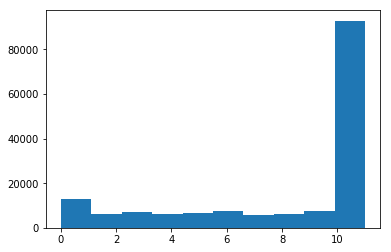

In [411]:
plt.hist(classes,bins=10)

(array([ 12482.,   6260.,   6059.,   6403.,   5591.,   7249.,   6102.,
          6070.,   7064.,  95258.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

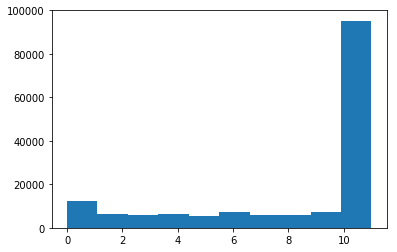

In [403]:
plt.hist(classes,bins=10)

(array([ 13909.,   6442.,  10015.,   6507.,   8567.,   8867.,   5738.,
          6198.,   9714.,  82581.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

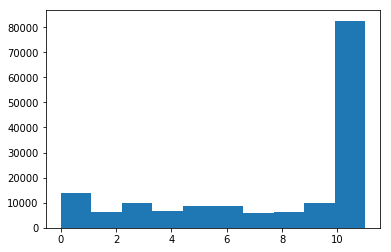

In [69]:
plt.hist(classes,bins=10)

(array([ 14037.,   7124.,  12571.,   6486.,  10360.,  11502.,   6549.,
          6624.,  10275.,  73010.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

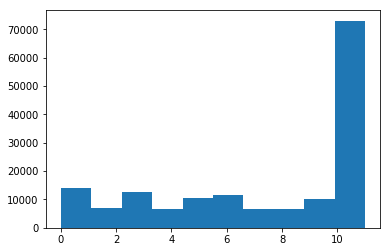

In [122]:
plt.hist(classes,bins=10)

### blending

### submission

In [412]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [413]:
with open('subm/submission_{}.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [414]:
from IPython.lib.display import FileLink

FileLink('subm/submission_{}.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/submission_aebase_aug_drp3_finetune_blend.csv